In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
# load dataset
df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df.sample(5)

,id,keyword,location,text,target
4576,6506,injuries,"Rockland County, NY",West Nyack Pineview Road railroad crossing off...,1
672,971,blaze,Mo.City,The mixtape is coming i promise. We goin in ri...,0
5238,7490,obliteration,NaN,Why did God order obliteration of ancient Cana...,0
6508,9307,survive,"gaffney, sc",how will I survive without dorrian,0
600,868,bioterror,Across the Atlantic,#BreakingNews http://t.co/gAN14PW9TG FedEx no ...,0


In [3]:
# check the shape of the dataset
df.shape

(7613, 5)

In [4]:
# basic info of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
# check for the null values
df.isna().sum() / df.shape[0] * 100

id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64

* location column consist 33% Null values. So, we are gonna drop that column.
* Id is not Important Column in this case. So, we will also drop that column.
* Keyword Consist Just 0.80% Null values. So, we will drop that values.

In [6]:
# drop redundant columns
df.drop(columns=["id","location"],inplace=True)

In [7]:
# drop null values 
df.dropna(inplace=True)
df.shape

(7552, 3)

In [8]:
# check for the duplicated values
df.duplicated().sum()

72

In [9]:
# drop duplicated values
df.drop_duplicates(keep="first",inplace=True)

In [10]:
# Merge Keyword and Text Column and create single Content Column.
df["content"] = df["keyword"] + " " + df["text"]
df.head()

,keyword,text,target,content
31,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,ablaze @bbcmtd Wholesale Markets ablaze http:/...
32,ablaze,We always try to bring the heavy. #metal #RT h...,0,ablaze We always try to bring the heavy. #meta...
33,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,ablaze #AFRICANBAZE: Breaking news:Nigeria fla...
34,ablaze,Crying out for more! Set me ablaze,0,ablaze Crying out for more! Set me ablaze
35,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,ablaze On plus side LOOK AT THE SKY LAST NIGHT...


In [11]:
df.iloc[2,3]

'ablaze #AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi'

# Data Preprocessing

1. Convert text to lowercase
2. tokenization
3. remove stopwords
4. remove punctuation
5. stemming

In [12]:
# import required libaries for preprocessing
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

ps = PorterStemmer()

In [13]:
# Function for entire text transformation
import re

def text_preprocessing(text): 
    # Convert text into lowercase
    text = text.lower()
    
    # remove link from the text
    text = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", text)
    
    # Tokenize text into list
    tokenize_text = nltk.word_tokenize(text)
    
    # remove Stopwords
    text_without_stopwords = [i for i in tokenize_text if i not in stopwords.words('english')]
    
    # Remove Punctuation
    text_without_punc = [i for i in text_without_stopwords if i not in string.punctuation]
    
    # fetch only alphanumeric values and apply stemming on that word
    transformed_text = [ps.stem(i) for i in text_without_punc if i.isalnum() == True]
    
    return " ".join(transformed_text)

In [14]:
# Let's Apply This Transformation Function on Our Content Column
df['transformed_content'] = df['content'].apply(text_preprocessing)

In [15]:
# Drop title author and old content column
final_df = df.drop(['text','keyword','content'],axis=1)

#### Let's make wordcloud of disaster and Not Disaster Tweets Respectively. so, we can analyze that which words are often used in both type of Tweets.

In [16]:
# import wordcloud
from wordcloud import WordCloud

# make object of wordcloud
wc = WordCloud(background_color='white',min_font_size=10,width=500,height=500)

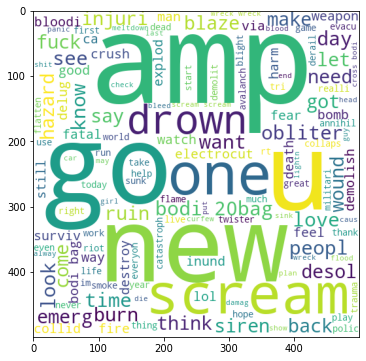

In [17]:
# WordCloud for True News
true_news_wc = wc.generate(final_df[final_df['target'] == 0]['transformed_content'].str.cat(sep=" "))
plt.figure(figsize=(8,6))
plt.imshow(true_news_wc)
plt.show()

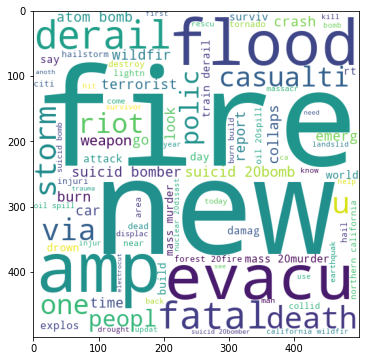

In [18]:
# WordCloud for Fake news
fake_news_wc = wc.generate(final_df[final_df['target'] == 1]['transformed_content'].str.cat(sep = " "))
plt.figure(figsize=(8,6))
plt.imshow(fake_news_wc)
plt.show()

We can clearly see from this wordcloud that which words are most used in both kind of Tweets.

##### Let's find specific Count of words.

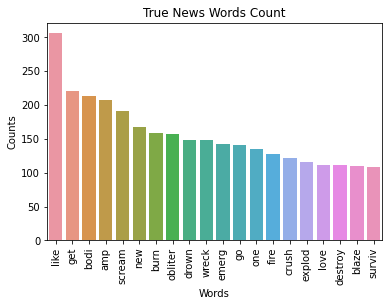

In [19]:
# library for Count Words
from collections import Counter

# create list of True News words
true_news_words_list = final_df[final_df['target']==0]['transformed_content'].str.cat(sep = " ").split()

# create DataFrame of that
true_news_words_df = pd.DataFrame(Counter(true_news_words_list).most_common(20))

# Now Let's Plot barplot of this words
sns.barplot(x=true_news_words_df[0],y=true_news_words_df[1])
plt.xticks(rotation='vertical')
plt.xlabel('Words')
plt.ylabel('Counts')
plt.title('True News Words Count')
plt.show()

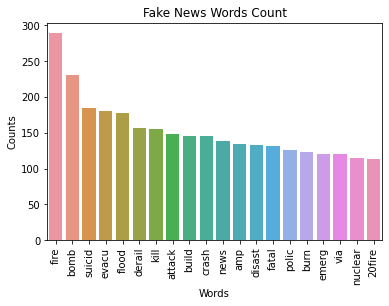

In [20]:
# create list of Fake News words
fake_news_words_list = final_df[final_df['target']==1]['transformed_content'].str.cat(sep = " ").split()

# create DataFrame of that
fake_news_words_df = pd.DataFrame(Counter(fake_news_words_list).most_common(20))

# Now Let's Plot barplot of this words
sns.barplot(x=fake_news_words_df[0],y=fake_news_words_df[1])
plt.xticks(rotation='vertical')
plt.xlabel('Words')
plt.ylabel('Counts')
plt.title('Fake News Words Count')
plt.show()

# Feature Splitting

In [21]:
# Let's Separate our Input and Output Columns
X = final_df['transformed_content'].values
y = final_df['target'].values

In [22]:
# let's do Train Test Split of Our Data
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

In [23]:
# let's do Train Test Split of Our Data
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
# Now Let's Do Vectorization of Transformed Content Using Bag of Words Technique
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

# create object of CountVectorizer
cf = CountVectorizer(max_features=5000)

In [24]:
# Convert X_train and Y_train into Vevtors
X_trf =  cf.fit_transform(X).toarray()
X_train = cf.fit_transform(X_train).toarray()
X_test = cf.transform(X_test).toarray()

# Model Building

In [25]:
# import required Models 
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB,GaussianNB,BernoulliNB
from sklearn.model_selection import GridSearchCV,ShuffleSplit,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score

In [26]:
# Function to Find Best Model and Parameters of that Model.
def check_model(X,y):
    algos = {
        'lgr':{
            'model':LogisticRegression(),
            'params':{
                'C':[0.1,0.01,1,0.5,2,10,20]
            }
        },
        'mnb':{
            'model':MultinomialNB(),
            'params':{
                
            }
        },
        'bnb':{
            'model':BernoulliNB(),
            'params':{
            
            }
        },
        'gnb':{
            'model':GaussianNB(),
            'params':{
            
            }
        },
    }
    
    score = []
    
    for model_name,config in algos.items():
        cv = ShuffleSplit(n_splits=5,test_size=0.2,random_state=42)
        gd = GridSearchCV(estimator=config['model'],param_grid=config['params'],n_jobs=-1,cv=cv)
        gd.fit(X,y)
        score.append({'model_name':model_name,'acc_score':gd.best_score_,'best_params':gd.best_params_})
        
    return pd.DataFrame(score)

In [27]:
# Model's Scores and their Best Parameters
# check_model(X_trf,y)

In [28]:
# Let's Evaluate Model
def model_evaluation(model,X_train,X_test,y_train,y_test):
    model.fit(X_train,y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    train_acc = accuracy_score(y_train,train_pred)
    test_acc = accuracy_score(y_test,test_pred)
    
    train_score = pd.Series({'accuracy_score':accuracy_score(y_train,train_pred),'precision_score':precision_score(y_train,train_pred)})
    test_score = pd.Series({'accuracy_score':accuracy_score(y_test,test_pred),'precision_score':precision_score(y_test,test_pred)})
    scorecard = pd.concat([train_score,test_score],axis=1)
    
    scorecard.columns = ['Train_data','Test_data']
    
    return scorecard

In [29]:
# Model Evaluation of Logistic Regression
model_evaluation(LogisticRegression(C=0.5),X_train,X_test,y_train,y_test)

,Train_data,Test_data
accuracy_score,0.900568,0.794786
precision_score,0.930304,0.788091
